In [1]:
import numpy as np
import scipy
import casadi as ca
from polytope import Polytope

import matplotlib.pyplot as plt

In [2]:
np.random.seed(1)

This notebook apply the tube-based robust MPC from the paper "Robust model predictive control of constrained linear systems with bounded disturbances" to the linear system with bounded disturbance from the same paper.

The methods "eps_MRPI" is taken from Tor Aksel N. Heirung's repository "pytope", and this application is realized based on this great python tool.

In [3]:
def eps_MRPI(A, W, epsilon, s_max=20):
    ''' Determines an outer epsilon-approximation of a minimal RPI set.

    Implements Algorithm 1 Raković et al. [1] for determining an outer 
    epsilon-approximation of the minimal RPI set for the autonomous system
    x+ = A*x + w
    using the following algorithm (copied directly from the paper and referenced 
    throughout the code):

    ALGORITHM 1: Computation of an RPI, outer epsilon-approximation of the MRPI 
    set F_infinity
    REQUIRE: A, W, and epsilon > 0
    ENSURE: F(alpha, s) such that 
        F_infinity <= F(alpha, s) <= F_infinity + B_infinity^n(epsilon)
      1: Choose any s in N (ideally, set s <- 0).
      2: REPEAT
      3:   Increment s by one.
      4:   Compute alpha^o(s) as in (11) and set alpha <- alpha^o(s).
      5:   Compute M(s) as in (13).
      6: UNTIL alpha <= epsilon / (epsilon + M(s))
      7: Compute F_s as the Minkowski sum (2) and scale it to give 
         F(alpha, s) := (1 - alpha)^(-1) * F_s.

    The s-term Minkowski sum (2) is computed in V-rep; computing the sum in
    H-rep can be both slow and numerically more challenging.

    Args:
    A: A numpy array (the state transition matrix --  must be strictly stable).
    W: A Polytope instance that bounds the disturbance w (must be compact and
      contain the origin).
    epsilon: A (positive) error bound (the radius of the infinity-norm ball).
    s_max: An optional maximum value of s, at which the algorithm terminates.

    Returns:
    F_alpha_s: A Polytope instance that is the outer-epsilon approximation of
      the MRPI set for (A, W).
    result: A dict with keys
      alpha: A scalar in [0, 1]:  A^s W subset alpha W  (Eq. (4)).
      s: A positive integer:  F_alpha_s := (1 - alpha)^(-1) F_s  (Eq. (5)).
      M: A numpy array (shape (s + 1,)) of the numbers M(k), k = 0, ..., s.
        The last element, M[-1], is M(s), which satisfies
        alpha <= epsilon / (epsilon + M(s))  (Eq. (14)).
      status: 0 if the algorithm terminated successfully, otherwise -1.
      alpha_o_s: A numpy array (shape (s + 1,)) of the number alpha at
        every iteration k = 0, ..., s.
      F_s: A numpy array of Polytope instances: F_s[s] is the s-term Minkowski
        sum from i = 0 to s over A^i W  (Eq. (2)).
      eps_min: The minimal epsilon that does not require increasing s.

    Raises:
    ValueError: An argument did not satisfy a necessary condition or the support
      function could not be evaluated successfully.

    Paper reference:
    [1] Raković, S.V., Kerrigan, E.C., Kouramas, K.I., & Mayne, D.Q. (2005).
    Invariant approximations of the minimal robust positively invariant set. IEEE
    Transactions on Automatic Control, 50(3), 406-410.
    '''

    status = -1  # set to 0 at successful termination (as in SciPy's linprog)

    m, n = A.shape
    if m != n:
        raise ValueError('A must be a square matrix')

    # The disturbance set W is in the form
    # W := {w in R^n | f_i' * w <= g_i, i in I}
    W.minimize_V_rep()
    F = W.A  # the columns f_i of A in the H-rep [A b] of W
    g = W.b  # the right-hand side b in the H-rep [A b] of W
    I = g.size  # the number of inequalities in the H-rep of W

    if not all(g > 0):
        raise ValueError('W does not contain the origin: g > 0 is not satisfied')

    # array of upper bounds on alpha values -- the scaling factor in the subset
    # condition A^s W subset alpha * W  (Eq. (10))
    alpha_o_s = np.full(s_max, np.nan)

    # To determine M(s) (used to bound the approximation error on F(alpha, s)):
    # Store support functions for each power of A, A^(s-1),
    # and each direction j = 1, ..., n. One row per s, each row has n support
    # functions for A^(s-1) positive and n for A^(s-1) negative; see (13).
    # M(s) is the maximum of all elements of each row s.
    # Store all values used to determine M(s) -- this is not necessary but useful
    # when debugging numerically challenging cases. Note that the first row
    # (s = 0) remains all zero (which is OK).
    M_s_row = np.zeros((s_max, 2 * n))  # each M(s) is the max over 2n values
    M = np.full(s_max, np.nan)  # M[s] is that maximum for each s

    # Pre-compute all powers of A, A^s, s = 0, ..., s_max

#     print(np.linalg.matrix_power(A, 0),np.linalg.matrix_power(A, 1),np.linalg.matrix_power(A, 2))
    A_pwr = np.stack([np.linalg.matrix_power(A, i) for i in range(s_max)])

    alpha_o = np.full(I, np.nan)

    # Step 1: Choose any s in N [natural numbers] (ideally, set s <- 0).
    s = 0

    # Step 2: repeat
    while s < s_max - 1:

        # Step 3: Increment s by one.
        s += 1

        # Step 4: Compute alpha^o(s) as in (11) and set alpha <- alpha^o(s).
        # alpha^o(s) = max_{i in I) h_W((A^s)' f_i) / g_i
        for i in range(I):
            fi = F[i, :].T
            h_W_i, status = W.support(A_pwr[s].T @ fi)
            if not status.success:
                print(f'Unsuccessful evaluation of the support function 'f'h_W((A^{s})'' * f_{s}): {status.message}')
            alpha_o[i] = h_W_i / g[i]
        alpha_o_s[s] = np.max(alpha_o)
        alpha = alpha_o_s[s]

        # Step 5: Compute M(s) as in (13).
        # M(s) = max_j {sum_i(h_W_sm1_pos_j), sum_i(h_W_sm1_neg_j)}  (Eq. (13))
        # At iteration s, evaluate the support for the rows of A^(s-1) and use the
        # supports evaluated at previous iterations s to evaluate the sum over i,
        # i = 0, ..., s - 1.
        h_W_sm1_pos_j = np.full(n, np.nan)  # h_W((A^(s-1))' * e_j, j = 0, ..., n-1
        h_W_sm1_neg_j = np.full(n, np.nan)  # h_W((-A^(s-1))' * e_j, j = 0, ..., n-1
        # Evaluate support in direction +- (A^i)' * e_j, with e_j the jth standard
        # basis vector in R^n. That is, (A^i)' * e_j is the jth column of (A^i)', or
        # the jth row of A^i (A_pwr_i[j])
        for j in range(n):
            A_pwr_i = A_pwr[s - 1]  # i = 0, ..., s - 1
            h_W_sm1_pos_j[j], status_lhs = W.support(A_pwr_i[j])
            h_W_sm1_neg_j[j], status_rhs = W.support(-A_pwr_i[j])
            if not all(status.success for status in (status_lhs, status_rhs)):
                raise ValueError(f'Unsuccessful evaluation of the support function in 'f'the direction of row {j} of A^{s - 1} (s = {s})')
        # Store all 2n support-function evaluations for this iteration s. That is,
        # {h_W((A^(s-1))' * e_j,  h_W((-A^(s-1))' * e_j}, j = 0, ..., n-1:
        M_s_row[s] = M_s_row[s - 1] + np.concatenate((h_W_sm1_pos_j, h_W_sm1_neg_j))
        # Take the sum over i from 0 to s - 1 (so include row s, hence ": s + 1"
        # M_s_argument = np.sum(M_s_row[s], axis=0)
        M[s] = np.max(M_s_row[s])  # Eq. (13), see above

        # Step 6: until alpha <= epsilon / (epsilon + M(s))
        if alpha <= epsilon / (epsilon + M[s]):
            status = 0  # success
            break

    s_final = s

    # Step 7: Compute F_s as the Minkowski sum (2) and scale it to give
    # F(alpha, s) = (1 - alpha)^(-1) F_s.
    # F_s = sum_{i = 0}^{s - 1} A^i W,  F_0 = {0}  (Eq. (2))
    F_s = np.full(s_final + 1, Polytope(n=n))  # F_s, s = 0, ..., s_final
    for s in range(1, s_final + 1):  # determine F_s for s = 1, ..., s_final
        F_s[s] = F_s[s - 1] + A_pwr[s - 1] * W  # F_s[0] is empty
        F_s[s].minimize_V_rep()  # critical when s_final is large
    # Scale to obtain the epsilon-approximation of the minimal RPI:
    F_alpha_s = F_s[s_final] * (1 / (1 - alpha))
    # TODO: Improve performance for large s_final by not constructing polytopes
    # for every s -- instead compute the vertices directly for every power of A
    # and add them together at the end (and finally remove redundant vertices)

    # The smallest epsilon for s_final terms in the Minkowski sum:
    eps_min = M[s_final] * alpha / (1 - alpha)

    result = {'alpha': alpha, 's': s_final, 'M': M[: s_final + 1],
            'status': status, 'alpha_o_s': alpha_o_s[: s_final + 1], 'F_s': F_s,
            'eps_min': eps_min}

    return F_alpha_s, result


In [4]:
def dlqr(A,B,Q,R):
    """
    Solve the discrete time lqr controller.
    x[k+1] = A x[k] + B u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    """
    # first, solve the ricatti equation
    P = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R))
    # compute the LQR gain
    K = np.matrix(scipy.linalg.inv(B.T*P*B+R)*(B.T*P*A))
    return -K

Find the nominal maximal invaraint set. ref: Model Predictive Control Classical, Robust and Stochastic p. 23

In [5]:
def v_index_opt(n_max, x_sym, F_DM, G_DM, K_DM, Phi_DM):
    '''
    Find the nominal maximal invaraint set. ref: Model Predictive Control Classical, Robust and Stochastic p. 23
    
    '''
    obj = -(F_DM+G_DM @ K_DM) @ ca.mpower(Phi_DM, n_max + 1) @ x_sym # Solve min -J  to find the max value for J
    obj_list = []

    Nobj = obj.shape[0]
    for i in range(Nobj):
        obj_list += [obj[i]]

    g = []
    for i in range(n_max+1):
        g += [(F_DM+G_DM @ K_DM) @ ca.mpower(Phi_DM, i) @ x_sym]
    Ng = ca.vertcat(*g).shape[0]

    probs_list = []
    for i in range(Nobj):
        nlp_prob = {
            'f': obj_list[i],
            'x': x_sym,
            'g': ca.vertcat(*g)
        }
        probs_list += [nlp_prob]

    solver_opt = {}
    solver_opt['print_time'] = False
    solver_opt['ipopt'] = {
        'max_iter': 500,
        'print_level': 1,
        'acceptable_tol': 1e-6,
        'acceptable_obj_change_tol': 1e-6
    }

    solver_list = []
    for i in range(Nobj):
        solver = ca.nlpsol("solver", "ipopt", probs_list[i], solver_opt)
        solver_list += [solver]


    lbg = [-ca.inf] * Ng
    ubg = [1] * Ng

    nl = {}
    nl['lbg'] = lbg
    nl['ubg'] = ubg

    sol_list = []
    for i in range(Nobj):
        sol = solver_list[i](**nl)
        sol_list += [-sol['f']]
        
    return sol_list

$$
x^{+}=\left[\begin{array}{ll}
1 & 1 \\
0 & 1
\end{array}\right] x+\left[\begin{array}{c}
0.5 \\
1
\end{array}\right] u+w,
$$
where $x \in \mathbb{X} \triangleq\{x [0 \, 1] x \leqslant 2\}$, $u \in \mathbb{U} \triangleq\{u|| u \mid \leqslant 1\}$, and $w \in W \triangleq\left\{w \mid\|w\|_{\infty} \leqslant 0.1\right\}$.

In [6]:
# Define the 
A = np.array([[1,1],[0,1]])
B = np.array([[0.5],[1]])
Q = np.eye(2)
R = np.diag([0.01])
P = np.array([[2.0066, 0.5099],[0.5099, 1.2682]])
K = np.array(dlqr(A,B,Q,R)) # feedback gain for positively invariant sets

Ak = np.array(A + B @ K)

Phi = A + B @ K

# Formulate constraint in the same fasion as in the reference book
F = np.array([[0,1/2],[0,0],[0,0]])
G = np.array([[0,1,-1]]).T

A_DM = ca.DM(A)
B_DM = ca.DM(B)
K_DM = ca.DM(K)
F_DM = ca.DM(F)
G_DM = ca.DM(G)

Phi_DM = A_DM + B_DM @ K_DM

nu = 1
nx = 2
nw = 2

In [7]:
W = Polytope(lb=(-0.1, -0.1), ub=(0.1, 0.1))

In [8]:
Z, result = eps_MRPI(Ak, W, 5e-4)

In [9]:
Z.H #A*x <= b and H = [A b]

array([[ 0.        , -1.        ,  0.25013637],
       [-1.        , -0.        ,  0.25178886],
       [ 0.        ,  1.        ,  0.25013637],
       [ 1.        , -0.        ,  0.25178886],
       [ 0.702457  ,  0.71172618,  0.14276915],
       [ 0.69537628,  0.71864583,  0.14393509],
       [-0.69537628, -0.71864583,  0.14393509],
       [-0.702457  , -0.71172618,  0.14276915],
       [ 0.70899042,  0.70521811,  0.14340799],
       [ 0.7092464 ,  0.70496067,  0.14344483],
       [-0.70899042, -0.70521811,  0.14340799],
       [-0.7092464 , -0.70496067,  0.14344483],
       [ 0.70949843,  0.70470701,  0.14350401],
       [ 0.70950864,  0.70469674,  0.14350656],
       [-0.70949843, -0.70470701,  0.14350401],
       [-0.70950864, -0.70469674,  0.14350656],
       [ 0.70951953,  0.70468578,  0.14350962],
       [ 0.70951871,  0.70468659,  0.14350939],
       [ 0.70951912,  0.70468618,  0.1435095 ],
       [-0.70951953, -0.70468578,  0.14350962],
       [-0.70951871, -0.70468659,  0.143

In [10]:
Z.V # Take vertices

array([[ 0.05151796, -0.25013637],
       [ 0.25178886, -0.25013637],
       [ 0.25178886, -0.04986547],
       [ 0.25125061, -0.04932353],
       [ 0.25097427, -0.0490453 ],
       [ 0.24934465, -0.04740449],
       [ 0.248508  , -0.04656211],
       [ 0.24357411, -0.04159438],
       [ 0.24104105, -0.03904395],
       [ 0.22610354, -0.02400445],
       [ 0.21843487, -0.01628363],
       [ 0.17324562,  0.02918034],
       [ 0.15006345,  0.05248651],
       [ 0.01596739,  0.18483618],
       [-0.05151796,  0.25013637],
       [-0.25178886,  0.25013637],
       [-0.25178886,  0.04986547],
       [-0.25125061,  0.04932353],
       [-0.25097427,  0.0490453 ],
       [-0.24934465,  0.04740449],
       [-0.248508  ,  0.04656211],
       [-0.24357411,  0.04159438],
       [-0.24104105,  0.03904395],
       [-0.22610354,  0.02400445],
       [-0.21843487,  0.01628363],
       [-0.17324562, -0.02918034],
       [-0.15006345, -0.05248651],
       [-0.01596739, -0.18483618]])

In [11]:
Z_proj_list = []
for i in range(np.shape(Z.V)[0]):
    Z_proj_list += [K @ Z.V[[i],:].T]
Z_proj = np.vstack(Z_proj_list)
Z_proj_max = Z_proj.max()
Z_proj_min = Z_proj.min()

In [12]:
x_sym = ca.SX.sym("x",nx)

n_max = 3
# Find the maximal v
v_index_opt(n_max, x_sym, F_DM, G_DM, K_DM, Phi_DM)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



[DM(0.0283938), DM(0.0380311), DM(0.0380311)]

In [13]:
V_T_list = []
for i in range(n_max):
    V_T_list += [(F_DM + G_DM @ K_DM) @ ca.mpower(Phi_DM, i)]
# Nominal positively invariant set
V_T_DM = ca.vertcat(*V_T_list)

In [14]:
V_T_np = np.array(V_T_DM)

A_VT = V_T_np
b_VT  = np.ones([np.shape(A_VT)[0],1])
P_VT = Polytope(A_VT, b_VT)

Assumption
$$
A_{K} X_{f} \subset X_{f}, X_{f} \subset \mathbb{X} \ominus Z, K X_{f} \subset \mathbb{U} \ominus K Z
$$

In [15]:
A_VT_extend = np.vstack([A_VT,K,-K,np.array([[0,1]])])
b_VT_extend = np.vstack([b_VT,1-Z_proj_max,-(-1-Z_proj_min), 2 - Z.V[:,1].max()])
# Refoprmulate for the Assumption
P_VT_extend = Polytope(A_VT_extend, b_VT_extend)
X_f_p_Z = P_VT_extend + Z

In [16]:
x0 = np.array([[-5],[-2]])

N_pred = 9

u_ub = [1]
u_nom_ub = [u_ub-Z_proj_max]

u_lb = [-1]
u_nom_lb = [-1-Z_proj_min]

x_ub = [ca.inf, 2]
x_lb = [-ca.inf, -ca.inf]

x_nom_ub = [ca.inf, 2 - Z.V[:,1].max()]
x_nom_lb = [-ca.inf, -ca.inf]

xi_var = ca.SX.sym('x', nx, N_pred)
x0_para = ca.SX.sym('x0', nx, 1)
ui_var = ca.SX.sym('u', nu, N_pred - 1)

obj = 0
g = []
for i in range(N_pred - 1):
    xk = xi_var[:, i]
    obj += xk.T @ Q @ xk +ui_var[:, i].T @ R @ ui_var[:, i]
    
    g += [xi_var[:, i+1] - (A @ xk + B @ ui_var[:, i])]

obj += xi_var[:, -1].T @ P @ xi_var[:, -1]
# g += [xi_var[:, -1] - (A_para @ xi_var[:, -2] + B_para @ ui_var[:,  -1])] # Terminal state

x0_constraint = Z.H[:,:nx]
g += [x0_constraint @ (x0_para - xi_var[:, 0] )]

Xf = P_VT_extend.H
g += [Xf[:,:nx] @ xi_var[:, -1]]

dec_list = [ca.reshape(xi_var, -1, 1), ca.reshape(ui_var, -1, 1)]
para_list = [x0_para]

nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 300,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}

solver = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)

In [17]:
N_sim = 20

nl = {}

lbg = [0] * (nx * (N_pred-1))
ubg = [0] * (nx * (N_pred-1))

ub_temp1 = Z.H[:,[nx]].flatten().tolist()
ub_temp2 = Xf[:, [nx]].flatten().tolist()

lbg += [-ca.inf] * (len(ub_temp1)+len(ub_temp2))
ubg += ub_temp1 + ub_temp2

nl['lbg'] = lbg
nl['ubg'] = ubg

lbx = x_nom_lb * N_pred + u_nom_lb * (N_pred - 1)
ubx = x_nom_ub * N_pred + u_nom_ub * (N_pred - 1)

nl['lbx'] = lbx
nl['ubx'] = ubx

x0 = np.array([[-5],[-2]])
x_traj_list = []
x_traj_list += [x0]
xk = x0

x_nom_list = []
for i in range(N_sim):  
    nl['p'] = xk
    sol = solver(**nl)
    vk = sol['x'][nx * N_pred : nx * N_pred + nu].full()
    x0_sol = sol['x'][:nx].full()
    uk = vk + K @ (xk - x0_sol)
    
    x_nom_list += [x0_sol]
    
    wk = np.random.uniform(-0.1,0.1,[2,1])
    xk_next = A @ xk + B @ uk + wk
    x_traj_list += [xk_next]
    
    xk = xk_next

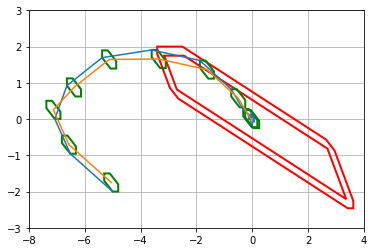

In [18]:
fig1, ax1 = plt.subplots(num=1)

plt.grid()
plt.axis([-8, 4, -3, 3])

# P_VT.plot(ax10, fill=False, edgecolor='r', linewidth=2)
Z.plot(ax1, fill=False, edgecolor='g', linewidth=2)
P_VT_extend.plot(ax1, fill=False, edgecolor='r', linewidth=2)
X_f_p_Z.plot(ax1, fill=False, edgecolor='r', linewidth=2)

x_traj_array = np.hstack(x_traj_list)
ax1.plot(x_traj_array[0,:],x_traj_array[1,:])

x_nom_array = np.hstack(x_nom_list)
ax1.plot(x_nom_array[0,:],x_nom_array[1,:])

for i in range(N_pred):
    (Z + x_nom_list[i]).plot(ax1, fill=False, edgecolor='g', linewidth=2)
# Xf_p_Z.plot(ax10, fill=False, edgecolor='r', linewidth=2)

Another way to find the MRPI set for terminal constraint:  ref: Model Predictive Control Classical, Robust and Stochastic p.73 and p.75

In [19]:
i_max = 5

nw = 2
w_sym = ca.SX.sym('w', nw)


h_list = []
h_diff_list = []

nh = F_DM.shape[0]
h0 = ca.DM([0]*nh)
h_list += [h0]
h_diff_list += [h0]


solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6
}

for i in range(1, i_max):
    h_temp = h_list[i-1]

    obj_list = []
    obj = - (F_DM + G_DM @ K_DM) @ ca.mpower(Phi_DM, i-1) @ w_sym

    Nobj = obj.shape[0]
    for j in range(Nobj):
        obj_list += [obj[j]]
        
    probs_list = []
    for i in range(Nobj):
        nlp_prob = {
            'f': obj_list[i],
            'x': w_sym,
        }
        probs_list += [nlp_prob]
    
    
    solver_list = []
    for i in range(Nobj):
        solver = ca.nlpsol("solver", "ipopt", probs_list[i], solver_opt)
        solver_list += [solver]
    
    lbx = [-0.1] * nw
    ubx = [0.1] * nw

    nl = {}
    nl['lbx'] = lbx
    nl['ubx'] = ubx

    sol_list = []
    for i in range(Nobj):
        sol = solver_list[i](**nl)
        sol_list += [-sol['f']]
        
#     print(sol_list)
    h_diff_list += [ca.vertcat(*sol_list)]
    h_list += [h_temp + ca.vertcat(*sol_list)]

In [20]:
h_list_np = [np.array(i) for i in h_list]
h_diff_list_np = [np.array(i) for i in h_diff_list]

In [21]:
E_temp1 = np.eye(nu)
E_temp2 = np.zeros([nu, (i_max-1) * nu])
E = np.hstack([E_temp1,E_temp2])

M_temp1 = np.eye(nu * (i_max - 1))
M_temp2 = np.vstack([M_temp1, np.zeros([nu, M_temp1.shape[1]])])

M = np.hstack([np.zeros([M_temp2.shape[0],nu]),M_temp2])


Psi = np.vstack([np.hstack([Phi, B @ E]), np.hstack([np.zeros([np.shape(M)[0],np.shape(Phi)[1]]), M])])

In [22]:
temp = np.hstack([(F + G @ K), G @ E]) @ np.linalg.matrix_power(Psi,i_max)

left_list = []

for i in range(i_max):
    left_temp = np.hstack([(F + G @ K), G @ E]) @ np.linalg.matrix_power(Psi,i)
    left_list += [left_temp[:,:nx]]

left_array = np.vstack(left_list)

In [23]:
one_temp = np.ones([nh,1])

right_list = []

for i in range(i_max):
    right_temp = one_temp - h_list_np[i]
    right_list += [right_temp]
right_arry = np.vstack(right_list)

P_XT = Polytope(left_array, right_arry)

(<matplotlib.patches.Polygon at 0x7f99e4cd29a0>,)

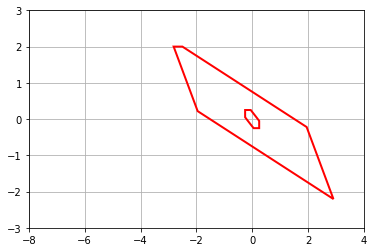

In [24]:
fig2, ax2 = plt.subplots(num=2)

plt.grid()
plt.axis([-8, 4, -3, 3])


Z.plot(ax2, fill=False, edgecolor='r', linewidth=2)
P_XT.plot(ax2, fill=False, edgecolor='r', linewidth=2)
